# Gene distance plots exploratory data analysis notebook

## What are the gene distance plots?

An attempt to investigate if the precision and recall of variant callers is affected by the distance between samples and references. However here we focus on regions that are common between the samples and the refs, thus we do not address the issues of reference incompleteness (i.e. we don't analyse regions that exclusive to the sample or the ref).

## How do we do this?

We first identify genes that are common between a pair `(sample, ref)`. For `snippy`, `ref` is each 226 references we use. For pandora, `ref` is simply the `pandora_multisample.vcf_ref.fa`. To identify these genes, we need a gene sequence that is as close as possible to the samples/refs. Thus we use the gene sequences in the `pandora_multisample.vcf_ref.fa`. We map the genes in `pandora_multisample.vcf_ref.fa` for each pair `(sample, ref)`, allowing us to know if the gene appears in the sample and its coordinates, in the ref and its coordinates, and the edit distance between them (in case they appear in both sample and ref).

Using the gene coordinates, we can infer how many variant calls lie on each identified gene, and if they are correct or incorrect (using the 4-way pipeline assessment), allowing us to know the precision ratio of the caller in that gene. The same for recall - we know how many truth variants lie on the gene, and how many the caller discovered. We plot these values by bins of genes split by its edit distance between the sample and the refs.

All of this is comprised in a snakemake pipeline, and this EDA notebook analyse the pipeline's output to check what is the best way to convey this data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
plt.rcParams['figure.dpi'] = 600
sns.set()


def display_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')


# Data input

For each triple `(gene, truth, reference)`, we know the nb of truth variants in that gene (`max_recall`), the nb of truth variants the tool was able to call (`observed_recall`) and thus the recall performance (`recall_ratio = observed_recall / max_recall`). We also know the edit distance of the gene between the ref and the truth (`distance`).

We also have the same stuff for precision.

In [2]:
df_pandora_precision = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_pandora_no_denovo_100x/get_gene_truth_ref_precision_proportion_distance/all_gene_truth_ref_precision_proportion_distance.csv")
df_pandora_precision["tool"] = "pandora"
df_snippy_precision = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_snippy/get_gene_truth_ref_precision_proportion_distance/all_gene_truth_ref_precision_proportion_distance.csv")
df_snippy_precision["tool"] = "snippy"
df_precision = pd.concat([df_pandora_precision, df_snippy_precision], ignore_index = True)
display(df_precision)

df_pandora_recall = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_pandora_no_denovo_100x/get_gene_truth_ref_recall_proportion_distance/all_gene_truth_ref_recall_proportion_distance.csv")
df_pandora_recall["tool"] = "pandora"
df_snippy_recall = pd.read_csv("/home/leandro/git/snippy_calls_gene_distance/tmp/evaluating_calls_output_snippy/get_gene_truth_ref_recall_proportion_distance/all_gene_truth_ref_recall_proportion_distance.csv")
df_snippy_recall["tool"] = "snippy"
df_recall = pd.concat([df_pandora_recall, df_snippy_recall], ignore_index = True)
display(df_recall)

,gene,truth,ref,distance,max_precision,observed_precision,precision_ratio,tool
0,Cluster_0,CFT073,pandora_vcf_ref_no_denovo,0.000000,8,8.000000,1.000000,pandora
1,Cluster_10,CFT073,pandora_vcf_ref_no_denovo,0.002004,3,3.000000,1.000000,pandora
2,Cluster_1001,CFT073,pandora_vcf_ref_no_denovo,0.065375,10,9.961538,0.996154,pandora
3,Cluster_1007,CFT073,pandora_vcf_ref_no_denovo,0.000000,1,1.000000,1.000000,pandora
4,Cluster_1009,CFT073,pandora_vcf_ref_no_denovo,0.002433,15,15.000000,1.000000,pandora
...,...,...,...,...,...,...,...,...
4244218,GC00010497,063_STEC,CP010140.1,0.026144,8,8.000000,1.000000,snippy
4244219,GC00010606,063_STEC,CP010140.1,0.067633,4,4.000000,1.000000,snippy
4244220,GC00010787,063_STEC,CP010140.1,0.020080,4,4.000000,1.000000,snippy
4244221,GC00010870,063_STEC,CP010140.1,0.015152,2,2.000000,1.000000,snippy


,gene,truth,ref,distance,max_recall,observed_recall,recall_ratio,tool
0,Cluster_10028,H131800734,pandora_vcf_ref_no_denovo,0.043478,5,5.0,1.000000,pandora
1,Cluster_10085,H131800734,pandora_vcf_ref_no_denovo,0.013333,6,0.0,0.000000,pandora
2,Cluster_1009,H131800734,pandora_vcf_ref_no_denovo,0.004866,6,5.0,0.833333,pandora
3,Cluster_10093,H131800734,pandora_vcf_ref_no_denovo,0.010989,2,2.0,1.000000,pandora
4,Cluster_10094,H131800734,pandora_vcf_ref_no_denovo,0.021978,5,5.0,1.000000,pandora
...,...,...,...,...,...,...,...,...
9409352,GC00010496,063_STEC,CP010140.1,0.030864,12,8.0,0.666667,snippy
9409353,GC00010497,063_STEC,CP010140.1,0.026144,9,6.0,0.666667,snippy
9409354,GC00010787,063_STEC,CP010140.1,0.020080,5,5.0,1.000000,snippy
9409355,GC00010870,063_STEC,CP010140.1,0.015152,3,3.0,1.000000,snippy


# Main configs

In [3]:
tools = ["pandora", "snippy"]
colors = ["red", "blue"]

# Main helper functions (please skip, go direct to the Results)

In [4]:
from matplotlib.lines import Line2D

def get_bounds(step, max_bin):
    bounds = [0.0]
    current_step = step
    while current_step <= max_bin:
        bounds.append(current_step)
        current_step += step
    assert len(bounds) > 0
    return bounds

def get_edit_distances(row, bounds):
    distance = row["distance"]
    for upper_bound in bounds[1:]:
        if distance < upper_bound:
            return upper_bound
    return bounds[-1]

def round_ed_label_and_return_str(row):
    return "%.2f"%round(row["edit_distance_labels"], 2)

def get_df_with_edit_distance_labels (df, max_precision_or_recall_column, having_at_least_n_variants, step, max_bin):
    df = df.query(f"{max_precision_or_recall_column} >= @having_at_least_n_variants")
    bounds = get_bounds(step, max_bin)
    edit_distance_labels = df.apply(get_edit_distances, axis=1, bounds=bounds)
    df["edit_distance_labels"] = edit_distance_labels
    df["edit_distance_labels_as_str"] = df.apply(round_ed_label_and_return_str, axis=1)
    return df

def get_df_with_edit_distance_labels_for_precision (df, step, max_bin):
    return get_df_with_edit_distance_labels(df, max_precision_or_recall_column="max_precision",
                                     having_at_least_n_variants=1, step=step, max_bin=max_bin)

def get_df_with_edit_distance_labels_for_recall (df, step, max_bin):
    return get_df_with_edit_distance_labels(df, max_precision_or_recall_column="max_recall",
                                     having_at_least_n_variants=1, step=step, max_bin=max_bin)

def init_plot(figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax

def save_figure(fig, output_filepath):
    fig.savefig(output_filepath, format="png", dpi=600)
    
def plot_lineplot_count_in_datapoints_in_several_bins(count_df, step, display_plot=False, display_dfs=False, output_filepath=None):
    fig, ax = init_plot()
    ax.set_xlabel(f"Edit distance (gene bins at each {step * 100}%)")
    ax.set_xlim([0.0, 0.2])
    ax.set_ylabel("Number of datapoints (gene, truth, ref) per bin")
    lineplot = sns.lineplot(x="edit_distance_labels", y="nb_of_datapoints", data=count_df, hue="tool")
    lineplot.set_yscale("log")
    
    if output_filepath is not None:
        save_figure(fig, output_filepath)
        
    if display_plot:
        ax.plot()
    
    if display_dfs:
        display_full(count_df.query("tool == 'pandora'"))
        display_full(count_df.query("tool == 'snippy'"))

def get_edit_distance_threshold_where_all_tools_have_at_least_the_min_nb_of_datapoints(count_df, min_nb_of_datapoints, nb_of_tools):
    edit_distance_and_nb_of_tools = count_df.query("nb_of_datapoints >= @min_nb_of_datapoints").groupby("edit_distance_labels").count()
    del edit_distance_and_nb_of_tools["nb_of_datapoints"]
    edit_distance_threshold_to_use = max(edit_distance_and_nb_of_tools.query("tool == @nb_of_tools").index)
    return edit_distance_threshold_to_use

def plot_violin_box_and_line_plots_to_axes(df, tool, color, ax):
    df = df.query("tool == @tool")
    
    sns.violinplot(x="edit_distance_labels_as_str", y="recall_ratio", data=df,
                   scale="count", cut=0, color=color, width=0.9/2, inner=None, linewidth=1.0,
                   ax=ax)
    sns.boxplot(x="edit_distance_labels_as_str", y="recall_ratio", data=df,
                 color=color, width=0.02, linewidth=0.3, showfliers=False, ax=ax)
    sns.lineplot(x="edit_distance_labels_as_str", y="recall_ratio", data=df,
                 estimator=np.median, color=color, linewidth=1.0, ci=None, ax=ax)
    sns.lineplot(x="edit_distance_labels_as_str", y="recall_ratio", data=df,
                 estimator=np.mean, color=color, linewidth=1.0, ci=None, ax=ax)
    ax.lines[-1].set_linestyle(":")
    plt.setp(ax.collections, alpha=.3)
    ax.set_ylim([-0.05, 1.05])



def plot_violin_and_line_for_recall_in_genes_in_several_bins(df, step, edit_distance_threshold, display_plot=False, output_filepath=None):
    fig, ax = init_plot((40, 3))
    df_with_edit_distance_threshold = df.query("edit_distance_labels <= @edit_distance_threshold")
    sorted_ed_labels = sorted(df_with_edit_distance_threshold["edit_distance_labels_as_str"].unique())
    
    
    plot_violin_box_and_line_plots_to_axes(df_with_edit_distance_threshold, tools[0], colors[0], ax)
    for tool, color in zip(tools[1:], colors[1:]):
        ax_bbox = ax.get_position()
        ax_2_bbox = ax_bbox
        x_shift = (ax_bbox.x1-ax_bbox.x0)/len(sorted_ed_labels)/2
        ax_2_bbox.x0 += x_shift
        ax_2_bbox.x1 += x_shift
        ax_2 = fig.add_axes(ax_2_bbox, frameon=False)
        plot_violin_box_and_line_plots_to_axes(df_with_edit_distance_threshold, tool, color, ax_2)
        ax_2.get_xaxis().set_visible(False)
        ax_2.get_yaxis().set_visible(False)
    

    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Recall ratio per bin')    
    ax.xaxis.set(ticks=np.arange(1/len(sorted_ed_labels)/2+ax_bbox.x0, len(sorted_ed_labels)+ax_bbox.x0), ticklabels=sorted_ed_labels)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    ax.xaxis.label.set_fontsize(30) 
    ax.yaxis.label.set_fontsize(26) 
    
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=tool)
                       for tool, color in zip(tools, colors)]
    ax.legend(handles=legend_elements, loc="lower left")
   
    if output_filepath is not None:
        save_figure(fig, output_filepath)
        
    if display_plot:
        plt.show()


def plot_line_for_precision_in_genes_in_several_bins(df, step, edit_distance_threshold, display_plot=False, output_filepath=None):
    fig, ax = init_plot((10, 3))
    df_with_edit_distance_threshold = df.query("edit_distance_labels <= @edit_distance_threshold")
    
    sns.lineplot(x="edit_distance_labels", y="precision_ratio", data=df_with_edit_distance_threshold, hue="tool",
                 estimator=np.median, linewidth=1.0, ci=None, ax=ax)
    ax_2 = fig.add_axes(ax.get_position(), frameon=False)
    sns.lineplot(x="edit_distance_labels", y="precision_ratio", data=df_with_edit_distance_threshold, hue="tool",
                 estimator=np.mean, linewidth=1.0, ci=None, ax=ax_2, legend=False)
    ax_2.lines[0].set_linestyle(":")
    ax_2.get_xaxis().set_visible(False)
    ax_2.get_yaxis().set_visible(False)

    ax.set(xlabel=f"Edit distance (gene bins at each {step*100}%)", ylabel='Recall ratio per bin')    
       
    if output_filepath is not None:
        save_figure(fig, output_filepath)
        
    if display_plot:
        plt.show()


# Cached dfs for easier processing (please skip, go direct to the Results)

In [5]:
def get_count_df(df):
    count_df = df.groupby(by=["edit_distance_labels", "tool"], as_index=False).count()
    count_df = count_df[["edit_distance_labels", "tool", "gene"]]
    count_df.columns = ["edit_distance_labels", "tool", "nb_of_datapoints"]
    return count_df


df_precision_with_step_001 = get_df_with_edit_distance_labels_for_precision(df_precision, step = 0.01, max_bin = 0.2)
count_df_precision_with_step_001 = get_count_df(df_precision_with_step_001)
df_recall_with_step_001 = get_df_with_edit_distance_labels_for_recall(df_recall, step = 0.01, max_bin = 0.2)
count_df_recall_with_step_001 = get_count_df(df_recall_with_step_001)

# Results

The following plots have:
* **violins normalized by counts per tool;**
* **boxplots included (zoom in to see them);**
* **line plots going through the median (solid) and mean (dotted);**

### To view them better, open the image in a new tab/window (many details, we have to make it wide to look well at them)

## Recall with 1% bins (show only until all tools have >= 50 datapoints; 1 datapoint = (gene, truth, ref)):

In [6]:
edit_distance_threshold_for_recall_where_all_tools_have_at_least_50_datapoints = \
    get_edit_distance_threshold_where_all_tools_have_at_least_the_min_nb_of_datapoints(
        count_df_recall_with_step_001,
        min_nb_of_datapoints = 50,
        nb_of_tools = 2)

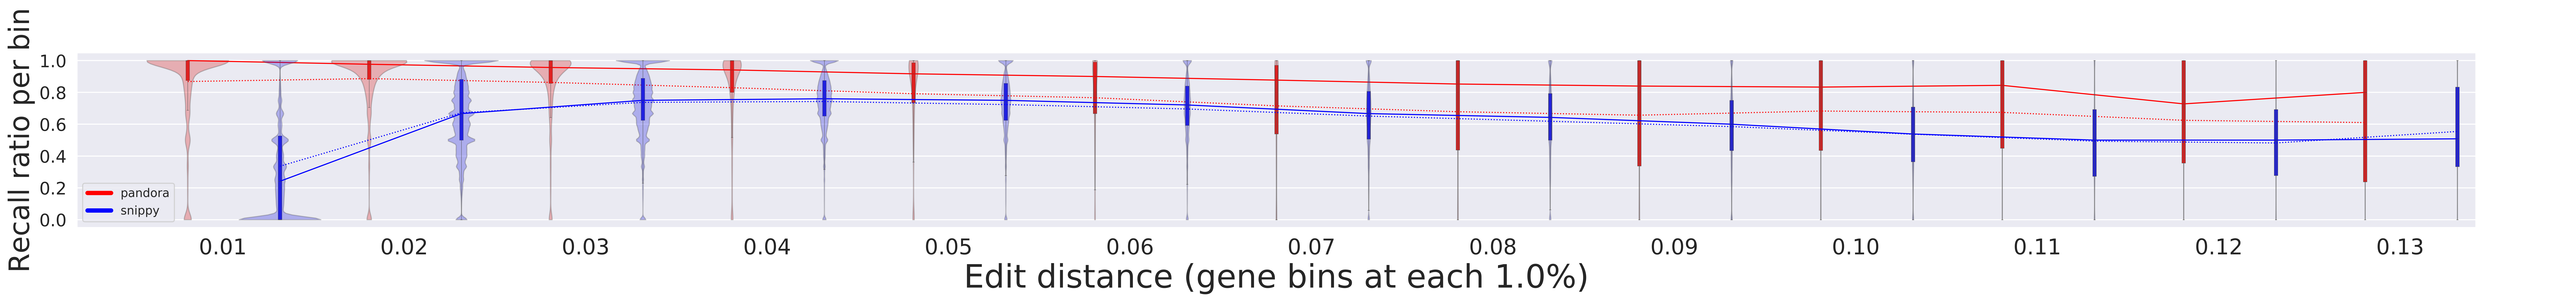

In [7]:
plot_violin_and_line_for_recall_in_genes_in_several_bins(
    df_recall_with_step_001, step=0.01, 
    edit_distance_threshold = edit_distance_threshold_for_recall_where_all_tools_have_at_least_50_datapoints,
    display_plot=True)

## Number of datapoints (1 datapoint = (gene, truth, ref)) in each bin (log scale)

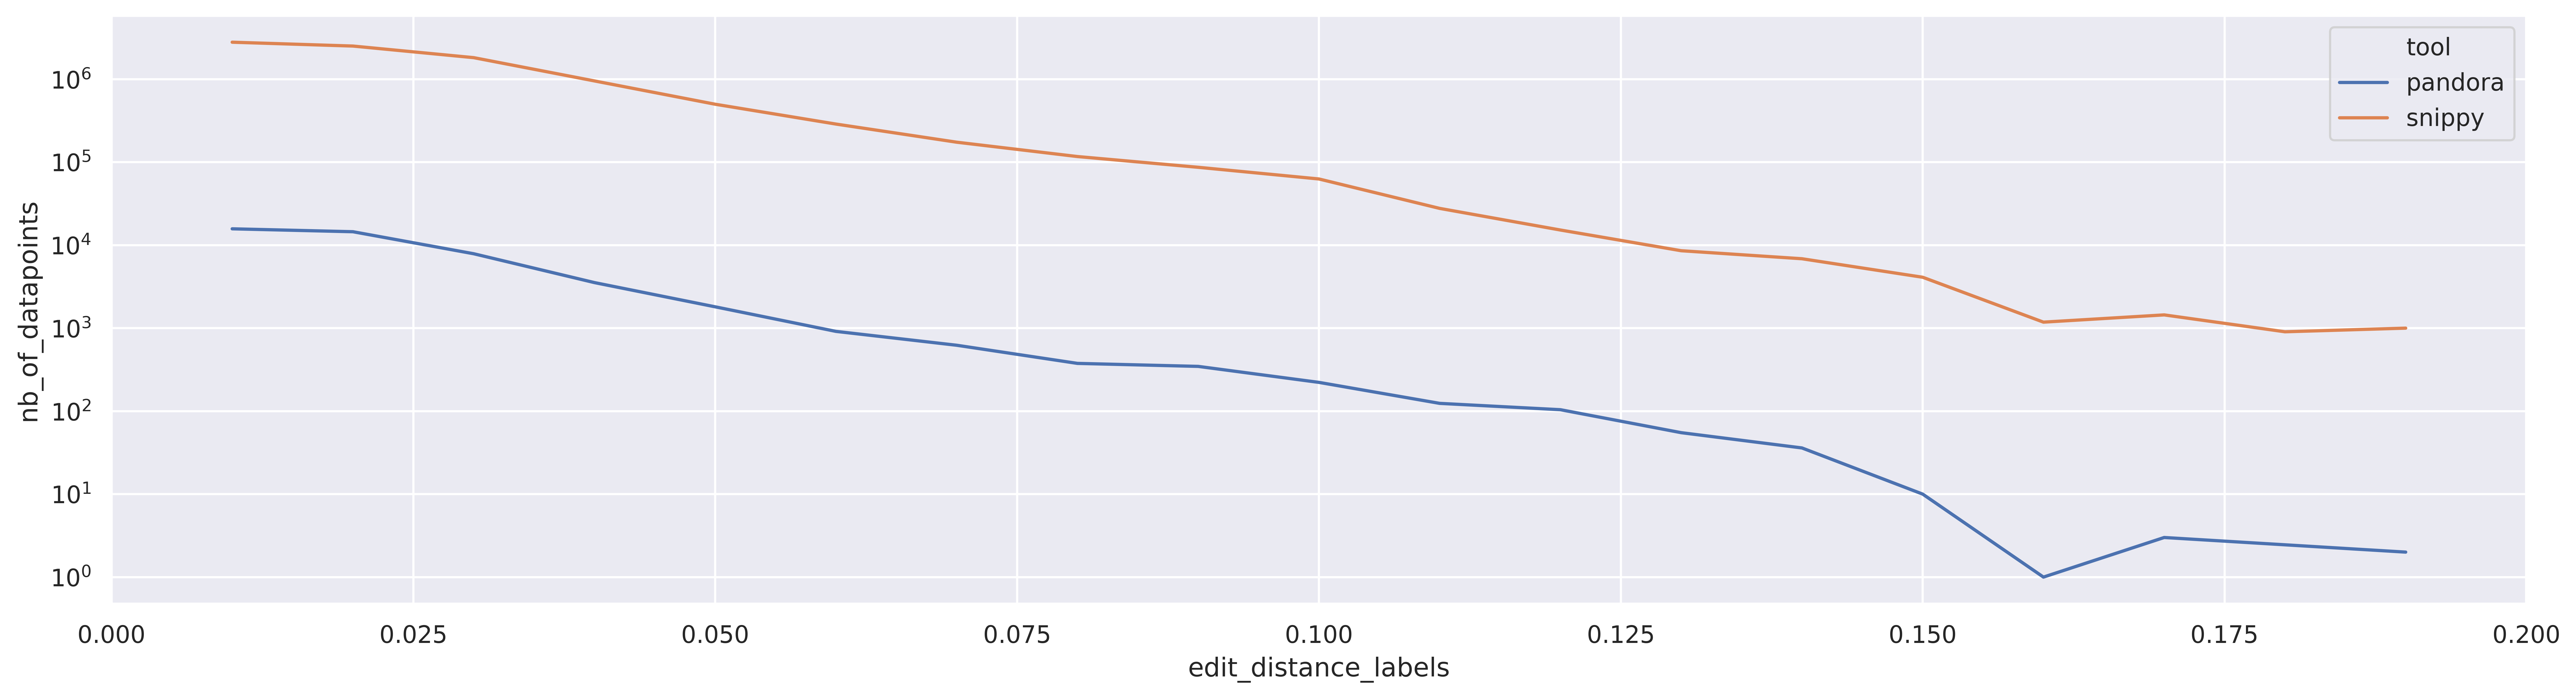

In [8]:
plot_lineplot_count_in_datapoints_in_several_bins(count_df_recall_with_step_001, step=0.01, display_plot=True)

## Precision with 1% bins (show only until all tools have >= 50 datapoints; 1 datapoint = (gene, truth, ref)):

In [9]:
edit_distance_threshold_for_precision_where_all_tools_have_at_least_50_datapoints = \
    get_edit_distance_threshold_where_all_tools_have_at_least_the_min_nb_of_datapoints(
        count_df_precision_with_step_001,
        min_nb_of_datapoints = 50,
        nb_of_tools = 2)

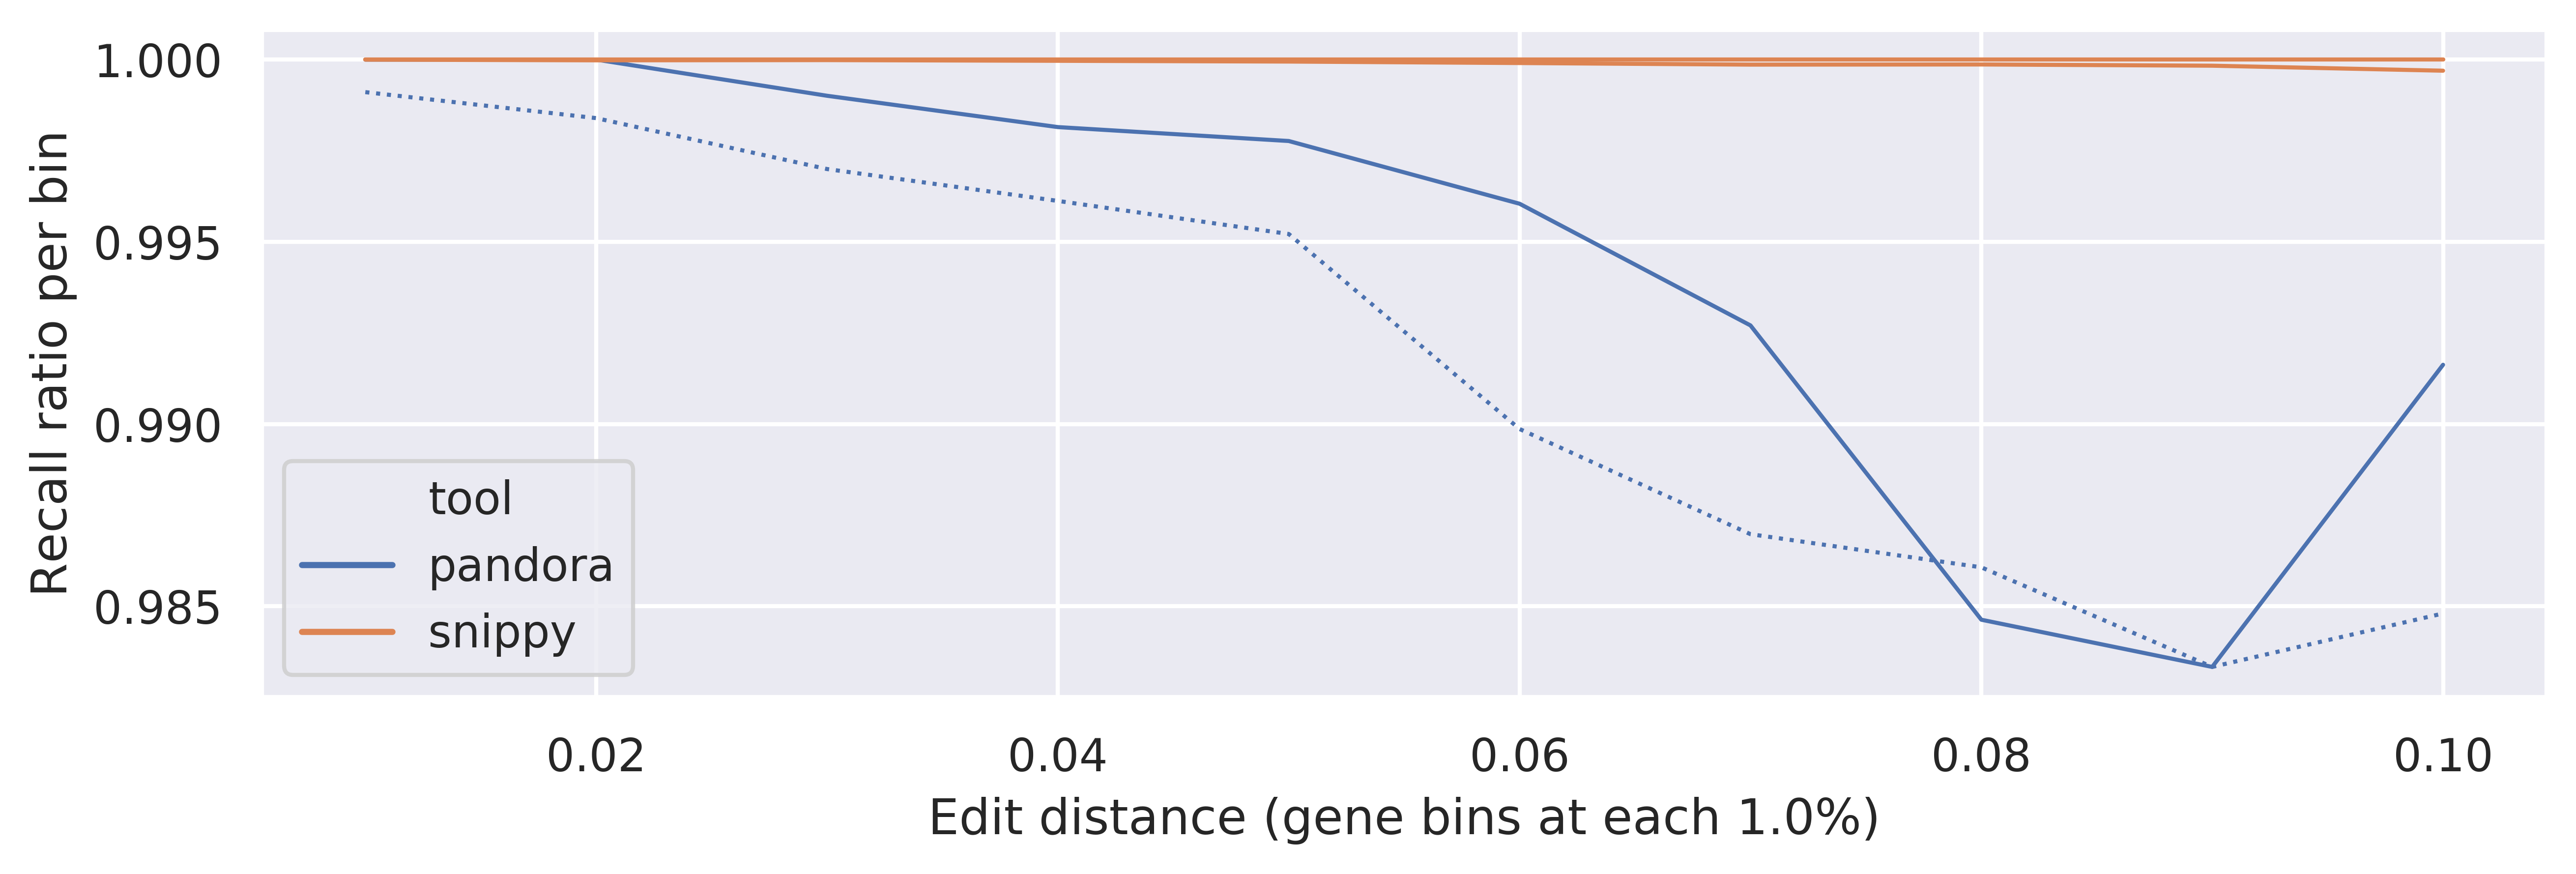

In [10]:
plot_line_for_precision_in_genes_in_several_bins(
    df_precision_with_step_001, step=0.01, 
    edit_distance_threshold = edit_distance_threshold_for_precision_where_all_tools_have_at_least_50_datapoints,
    display_plot=True)

## Number of datapoints (1 datapoint = (gene, truth, ref)) in each bin (log scale)

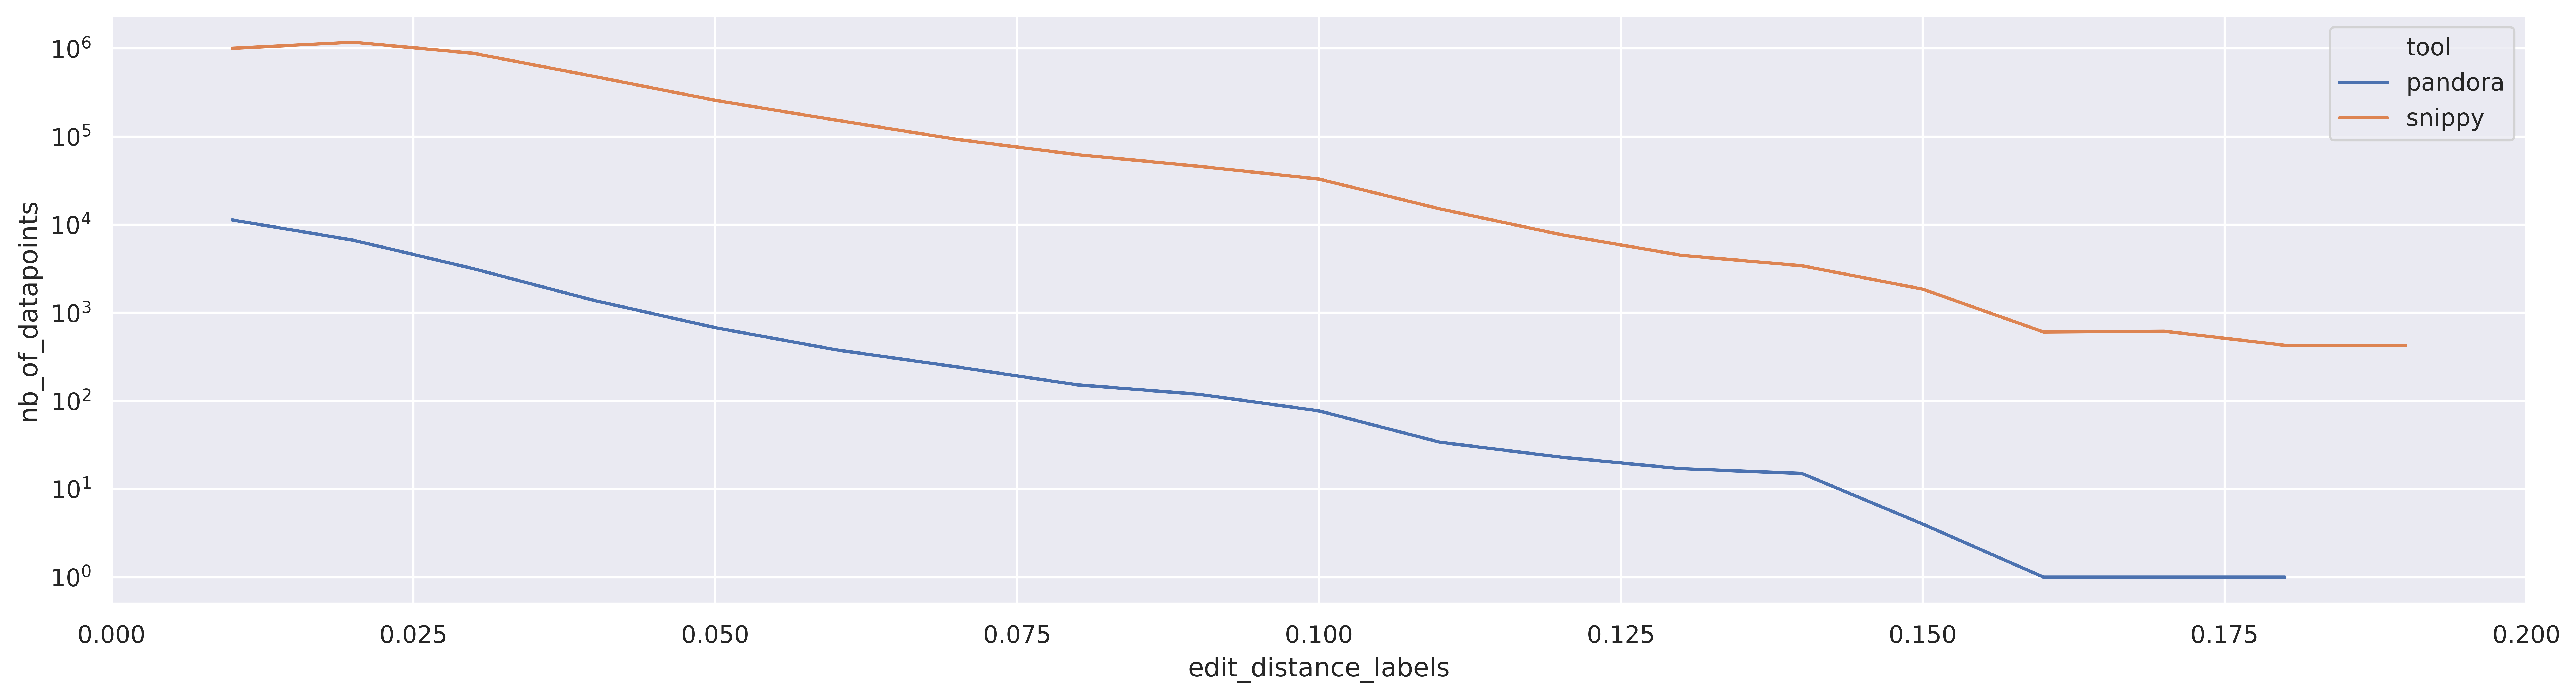

In [11]:
plot_lineplot_count_in_datapoints_in_several_bins(count_df_precision_with_step_001, step=0.01, display_plot=True)

# Pandora recall debugging

In [ ]:
df_pandora_recall

nb of genes per truth sample

In [ ]:
df_pandora_recall.query("gene == 'Cluster_10085'")




# (SKIP - WIP) Investigating why the nb of genes between recall and precision differ

In [ ]:
test_csv = pd.DataFrame({"f1": ["a", "b", "c"], "f2": [0,"",2]})
test_csv.to_csv("test.csv")


In [ ]:
count_df_recall_with_step_001

In [ ]:
count_merged_df = merged_df.groupby(by=["edit_distance_labels", "tool"], as_index=False).agg({
    "precision_ratio": ["count", "mean"],
    "recall_ratio": ["mean"],
})
count_df.columns = ["edit_distance_labels", "tool", "nb of data points in bin", "mean precision in bin", "mean recall in bin"]

display(count_df)

In [ ]:
gene_truth_and_count_for_precision_0001 = df_precision_with_step_0001.groupby(by=["gene", "truth", "ref"]).count()
gene_truth_and_count_for_recall_0001 = df_recall_with_step_0001.groupby(by=["gene", "truth", "ref"]).count()

In [ ]:
import numpy as np

def get_nb_of_genes_in_precision_and_recall(df_tool_precision, df_tool_recall, tool):
    gene_truth_and_count_for_precision = df_tool_precision.groupby(by=["gene", "truth", "ref"]).count()
    nb_points_in_precision = len(gene_truth_and_count_for_precision)
    print(f"For {tool}: Nb of (gene, truth, count) in precision: {nb_points_in_precision}")
    
    gene_truth_and_count_for_recall = df_tool_recall.groupby(by=["gene", "truth", "ref"]).count()
    nb_points_in_recall = len(gene_truth_and_count_for_recall)
    print(f"For {tool}: Nb of (gene, truth, count) in recall: {nb_points_in_recall}")

    outer_merged_df = gene_truth_and_count_for_precision.merge(gene_truth_and_count_for_recall, how="outer", on=["gene", "truth", "ref"], suffixes=("_precision", "_recall"))

    common_points = outer_merged_df.query("distance_precision.notnull() & distance_recall.notnull()", engine="python")
    nb_common_points = len(common_points)
    print(f"For {tool}: Nb of (gene, truth, count) in common: {nb_common_points}")

    points_only_in_precision = outer_merged_df.query("distance_precision.notnull() & distance_recall.isnull()", engine="python")
    nb_points_only_in_precision = len(points_only_in_precision)
    print(f"For {tool}: Nb of (gene, truth, count) only in precision: {nb_points_only_in_precision}")
    
    assert nb_common_points + nb_points_only_in_precision == nb_points_in_precision

    points_only_in_recall = outer_merged_df.query("distance_precision.isnull() & distance_recall.notnull()", engine="python")
    nb_points_only_in_recall = len(points_only_in_recall)
    print(f"For {tool}: Nb of (gene, truth, count) only in recall: {nb_points_only_in_recall}")
    
    assert nb_common_points + nb_points_only_in_recall == nb_points_in_recall

get_nb_of_genes_in_precision_and_recall(df_pandora_precision, df_pandora_recall, "pandora")
get_nb_of_genes_in_precision_and_recall(df_snippy_precision, df_snippy_recall, "snippy")